In [1]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas as pd

# We are also going to do some basic viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'fitness',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

connection = pg.connect(**connection_args)  # What is that "**" there??

### Alternative approach
Get this directly into pandas by using the xport package
1) pull in through xport (first install the xport package) 
2) then use the below package and it will come out as a pandas dataframe as shown below

Note that this approach was not used, and instead using a SQL database for practice with SQL

In [6]:
import xport.v56

In [7]:
with open('Data/BMX_J.xpt', 'rb') as f:
    library = xport.v56.load(f)

In [8]:
library['BMX_J']

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,BMXLEG,BMILEG,BMXARML,BMIARML,BMXARMC,BMIARMC,BMXWAIST,BMIWAIST,BMXHIP,BMIHIP
0,93703.0,1.0,13.7,3.0,89.6,NaN,NaN,NaN,88.6,NaN,...,NaN,NaN,18.0,NaN,16.2,NaN,48.2,NaN,NaN,NaN
1,93704.0,1.0,13.9,NaN,95.0,NaN,NaN,NaN,94.2,NaN,...,NaN,NaN,18.6,NaN,15.2,NaN,50.0,NaN,NaN,NaN
2,93705.0,1.0,79.5,NaN,NaN,NaN,NaN,NaN,158.3,NaN,...,37.0,NaN,36.0,NaN,32.0,NaN,101.8,NaN,110.0,NaN
3,93706.0,1.0,66.3,NaN,NaN,NaN,NaN,NaN,175.7,NaN,...,46.6,NaN,38.8,NaN,27.0,NaN,79.3,NaN,94.4,NaN
4,93707.0,1.0,45.4,NaN,NaN,NaN,NaN,NaN,158.4,NaN,...,38.1,NaN,33.8,NaN,21.5,NaN,64.1,NaN,83.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,102952.0,1.0,49.0,NaN,NaN,NaN,NaN,NaN,156.5,NaN,...,34.4,NaN,32.6,NaN,25.1,NaN,82.2,NaN,87.3,NaN
8700,102953.0,1.0,97.4,NaN,NaN,NaN,NaN,NaN,164.9,NaN,...,38.2,NaN,36.6,NaN,40.6,NaN,114.8,NaN,112.8,NaN
8701,102954.0,1.0,69.1,NaN,NaN,NaN,NaN,NaN,162.6,NaN,...,39.2,NaN,35.2,NaN,26.8,NaN,86.4,NaN,102.7,NaN
8702,102955.0,1.0,111.9,NaN,NaN,NaN,NaN,NaN,156.6,NaN,...,39.2,NaN,35.0,NaN,44.5,NaN,113.5,NaN,128.3,NaN


## EDA

In [9]:
query = '''
SELECT DISTINCT dxx.seqn, 
	CASE demo.riagendr WHEN '1.0' THEN 'M' WHEN '2.0' THEN 'F' ELSE demo.riagendr END, 
	demo.ridageyr, dxx.dxdtopf, paq.paq610, paq.paq625, paq.paq640, paq.paq655, paq.paq670, fat.category
FROM dxx
LEFT JOIN demo
	ON dxx.seqn = demo.seqn
LEFT JOIN paq
	ON dxx.seqn = paq.seqn
JOIN fat
	ON demo.riagendr = fat.gender AND dxdtopf >= fat.low AND dxdtopf < fat.high
WHERE demo.ridageyr >= 18
ORDER BY dxx.seqn
'''

df = pd.read_sql(query, connection)


In [10]:
len(df)

2452

In [11]:
df

,seqn,riagendr,ridageyr,dxdtopf,paq610,paq625,paq640,paq655,paq670,category
0,93706.0,M,18.0,22.7,NaN,NaN,5.0,NaN,2.0,Average
1,93711.0,M,56.0,22.8,NaN,NaN,5.0,4.0,2.0,Average
2,93712.0,M,18.0,16.7,6.0,6.0,NaN,4.0,3.0,Fitness
3,93714.0,F,54.0,42.1,NaN,NaN,NaN,NaN,NaN,Obese
4,93717.0,M,22.0,20.4,NaN,NaN,7.0,NaN,NaN,Average
...,...,...,...,...,...,...,...,...,...,...
2447,102935.0,F,27.0,33.7,3.0,NaN,4.0,1.0,1.0,Obese
2448,102944.0,M,55.0,33.4,NaN,5.0,NaN,NaN,NaN,Obese
2449,102948.0,F,31.0,27.7,NaN,NaN,NaN,5.0,NaN,Average
2450,102949.0,M,33.0,15.5,3.0,7.0,7.0,NaN,NaN,Fitness


In [12]:
colnames = {
    "seqn": "id",
    "riagendr": "gender",
    "ridageyr": "age",
    "dxdtopf": "body_fat",
    "paq610": "vig_work_days",
    "paq625": "mod_work_days",
    "paq640": "walk_bike_days",
    "paq655": "vig_rec_days",
    "paq670": "mod_work_days"
}

In [13]:
df = df.rename(columns = colnames)

In [14]:
df

,id,gender,age,body_fat,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_work_days,category
0,93706.0,M,18.0,22.7,NaN,NaN,5.0,NaN,2.0,Average
1,93711.0,M,56.0,22.8,NaN,NaN,5.0,4.0,2.0,Average
2,93712.0,M,18.0,16.7,6.0,6.0,NaN,4.0,3.0,Fitness
3,93714.0,F,54.0,42.1,NaN,NaN,NaN,NaN,NaN,Obese
4,93717.0,M,22.0,20.4,NaN,NaN,7.0,NaN,NaN,Average
...,...,...,...,...,...,...,...,...,...,...
2447,102935.0,F,27.0,33.7,3.0,NaN,4.0,1.0,1.0,Obese
2448,102944.0,M,55.0,33.4,NaN,5.0,NaN,NaN,NaN,Obese
2449,102948.0,F,31.0,27.7,NaN,NaN,NaN,5.0,NaN,Average
2450,102949.0,M,33.0,15.5,3.0,7.0,7.0,NaN,NaN,Fitness


In [15]:
df.isnull().sum()

id                   0
gender               0
age                  0
body_fat             0
vig_work_days     1747
mod_work_days     1324
walk_bike_days    1749
vig_rec_days      1595
mod_work_days     1336
category             0
dtype: int64

In [16]:
df = df.fillna(value=0)

In [18]:
import sklearn
from sklearn.model_selection import train_test_split

In [19]:
df_train, df_test = train_test_split(df, test_size=.20, random_state=42)

In [20]:
df_train.corr()

,id,age,body_fat,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_work_days
id,1.000000,0.007401,-0.013178,-0.034804,-0.053481,-0.029830,-0.031716,0.031459
age,0.007401,1.000000,0.186274,-0.074441,-0.060302,-0.075722,-0.252706,-0.058930
body_fat,-0.013178,0.186274,1.000000,-0.142347,-0.088244,-0.103957,-0.217436,-0.075629
vig_work_days,-0.034804,-0.074441,-0.142347,1.000000,0.343931,0.057741,0.042872,0.018735
mod_work_days,-0.053481,-0.060302,-0.088244,0.343931,1.000000,0.033942,0.034417,0.056682
walk_bike_days,-0.029830,-0.075722,-0.103957,0.057741,0.033942,1.000000,0.015264,0.050300
vig_rec_days,-0.031716,-0.252706,-0.217436,0.042872,0.034417,0.015264,1.000000,0.235260
mod_work_days,0.031459,-0.058930,-0.075629,0.018735,0.056682,0.050300,0.235260,1.000000


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 1436 to 860
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1961 non-null   float64
 1   gender          1961 non-null   object 
 2   age             1961 non-null   float64
 3   body_fat        1961 non-null   float64
 4   vig_work_days   1961 non-null   float64
 5   mod_work_days   1961 non-null   float64
 6   walk_bike_days  1961 non-null   float64
 7   vig_rec_days    1961 non-null   float64
 8   mod_work_days   1961 non-null   float64
 9   category        1961 non-null   object 
dtypes: float64(8), object(2)
memory usage: 168.5+ KB


In [22]:
X_train = df_train.iloc[:,4:9]
y_train = df_train.iloc[:,9]
X_test = df_test.iloc[:,4:9]
y_test = df_test.iloc[:,9]

In [23]:
X_train.head()

,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_work_days
1436,2.0,0.0,0.0,0.0,0.0
1815,0.0,0.0,0.0,0.0,0.0
2157,5.0,5.0,0.0,2.0,3.0
2037,0.0,0.0,0.0,0.0,0.0
736,0.0,0.0,0.0,0.0,2.0


(array([1453.,    0.,    0.,  379.,    0.,    0.,  105.,    0.,    0.,
          24.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

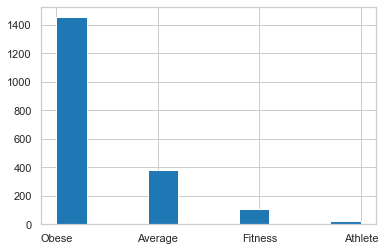

In [107]:
plt.hist(y_train)

In [110]:
len(y_train)

1961

In [ ]:
#note that histogram of this indicates that there is an imbalanced problem

# Modeling

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [32]:
from sklearn import tree

In [33]:
import numpy as np

In [39]:
naive_array = np.array([[0,0,0,1]]*len(y_train))

In [100]:
naive = pd.Series(['Obese']*len(y_train))

In [113]:
metrics.precision_score(y_train, naive, average = 'macro')
#note that micro will simply calculate true positives / (TP+FP), in multiclass this equals TP/all guesses = 74%
#macro will calculate TP/(TP+FP) for each class, then average across. In naive case, this is 74%*0.25 because 
#weighted this is 74%* 74% (precision for obese*obese percentage) + 0%*19% (percentage average) + 0*5%(percent fit) +0*2% (percent athlete)

0.1852371239163692

In [34]:
import graphviz

In [ ]:
#Process
#For each algorithm - Decision Tree, KNeighbors, Logistic Regression, XGBoost -:
    
#    Find the best parameters for each algorithm

In [139]:
DTC = DecisionTreeClassifier(max_depth=10)
test_score, train_score, fit_time = cross_validate(DTC,X_train,y_train,cv=10,scoring='average_precision')
 

ValueError: multiclass format is not supported

In [35]:
def model_eval(model):
    model.fit(X_train,y_train)
    test_score, train_score, fit_time = model_selection.cross_validate(model,X_train,y_train,cv=10,scoring='balanced_precision')
    return test_score, train_score, fit_time

In [38]:
y_train.unique()

array(['Obese', 'Average', 'Fitness', 'Athlete'], dtype=object)

In [46]:
weighted_roc_auc_ovr = metrics.roc_auc_score(y_test, DTC_prob, multi_class="ovo",
                                     average="weighted")

In [49]:
weighted_roc_auc_ovr

0.5206758887077197

In [50]:
len(X_train)

1961

In [51]:
test_conf = metrics.confusion_matrix(y_test, DTC.predict(X_test),labels=['Athlete','Fitness','Average','Obese'])

In [52]:
test_conf = pd.DataFrame(test_conf, columns=['Athlete','Fitness','Average','Obese'], index = ['Athlete','Fitness','Average','Obese'])

In [53]:
test_conf

,Athlete,Fitness,Average,Obese
Athlete,0,1,0,3
Fitness,0,1,3,18
Average,0,0,11,82
Obese,0,9,26,337


In [54]:
import seaborn as sns

In [55]:
import matplotlib.pyplot as plt

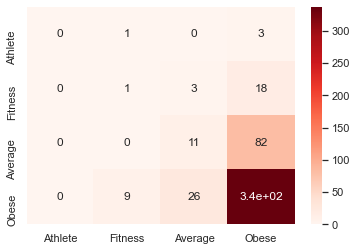

In [56]:
sns.heatmap(test_conf, annot = True, cmap="Reds")

In [57]:
naive_conf = metrics.confusion_matrix(y_test, naive,labels=['Athlete','Average','Fitness','Obese'])

In [58]:
naive_conf

array([[  0,   0,   0,   4],
       [  0,   0,   0,  93],
       [  0,   0,   0,  22],
       [  0,   0,   0, 372]])

In [59]:
score_points = np.array([[1,0.2,0.8,0],[0.2,1,0.4,0.6],[0.8,0.4,1,.2],[0,.6,.2,1]])

In [60]:
score_points

array([[1. , 0.2, 0.8, 0. ],
       [0.2, 1. , 0.4, 0.6],
       [0.8, 0.4, 1. , 0.2],
       [0. , 0.6, 0.2, 1. ]])

In [61]:
DTC_prob

array([[0.        , 0.22222222, 0.        , 0.77777778],
       [0.        , 0.        , 0.        , 1.        ],
       [0.01149425, 0.1954023 , 0.03448276, 0.75862069],
       ...,
       [0.01136364, 0.25      , 0.06818182, 0.67045455],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.14673913, 0.03804348, 0.81521739]])

In [62]:
y_test

2114      Obese
700       Obese
1165    Average
2416    Average
1626      Obese
         ...   
1491      Obese
192       Obese
289       Obese
174     Average
907       Obese
Name: category, Length: 491, dtype: object

In [63]:
from sklearn.preprocessing import LabelBinarizer

In [64]:
lb = LabelBinarizer()
lb.fit(['Athlete','Average','Fitness','Obese'])

LabelBinarizer()

In [65]:
y_test_bin = lb.transform(y_test)
y_test_bin

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

In [66]:
len(y_test_bin)

491

In [67]:
y_test_bin[0]

array([0, 0, 0, 1])

In [68]:
len(np.matmul(y_test_bin,score_points))

491

In [69]:
interstep = np.matmul(y_test_bin,score_points)

In [70]:
interstep[0]

array([0. , 0.6, 0.2, 1. ])

In [71]:
DTC_prob[0]

array([0.        , 0.22222222, 0.        , 0.77777778])

In [72]:
fin = interstep*DTC_prob

In [73]:
len(fin)

491

In [74]:
fin_score = fin.sum()/len(fin)

In [75]:
fin_score

0.8089475371046769

### Confusion Matrix and Scoring

In [76]:
def a_score(confusion_matrix,score_points=score_points):
    return np.sum(confusion_matrix*score_points)/np.sum(confusion_matrix)

In [77]:
a_score(test_conf)

Athlete         NaN
Fitness    0.600000
Average    0.435000
Obese      0.827727
dtype: float64

In [78]:
a_score(naive_conf)

0.880244399185336

In [81]:
lr = LogisticRegression(C=1000)
lr.fit(X_train,y_train)
lr_acc = accuracy_score(y_test,lr.predict(X_test))

In [82]:
lr_acc

0.7637474541751528

In [83]:
lr_prob = lr.predict_proba(X_test)

In [84]:
lr_prob

array([[0.01039744, 0.18355672, 0.04859843, 0.75744741],
       [0.01023431, 0.19532115, 0.05187621, 0.74256833],
       [0.01177487, 0.18541982, 0.04730417, 0.75550115],
       ...,
       [0.0087031 , 0.19964388, 0.05074385, 0.74090917],
       [0.01152939, 0.14947342, 0.03779819, 0.80119899],
       [0.00356676, 0.14887602, 0.0374094 , 0.81014782]])

In [85]:
sklearn.metrics.precision_score(y_test,DTC.predict(X_test),average='micro')

0.7107942973523421

In [86]:
DTC_acc

0.7107942973523421

In [87]:
X_test

,vig_work_days,mod_work_days,walk_bike_days,vig_rec_days,mod_work_days
2114,6.0,6.0,0.0,0.0,0.0
700,5.0,5.0,2.0,0.0,0.0
1165,0.0,0.0,0.0,2.0,1.0
2416,3.0,3.0,0.0,0.0,0.0
1626,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
1491,5.0,5.0,0.0,0.0,0.0
192,0.0,6.0,0.0,0.0,0.0
289,0.0,0.0,7.0,0.0,0.0
174,0.0,0.0,0.0,1.0,3.0


In [91]:
import matplotlib.pyplot as plt

In [92]:
plt.hist(TPF.dxdtopf)

NameError: name 'TPF' is not defined

In [90]:
len(TPF.seqn)-len(TPF_small.seqn)

NameError: name 'TPF' is not defined